In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import cv2
import random
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from mmdet.apis import init_detector, inference_detector


In [3]:
# Specify the path to model config and checkpoint file
config_file = '../experiments/moby_swin_t_imnet_finetune_100e/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_100ep_gwhd.py'
checkpoint_file = '../experiments/moby_swin_t_imnet_finetune_100e/latest.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


In [4]:

class WheatDatasetPredict(Dataset):
    """A dataset example for GWC 2021 competition."""

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = Path(root_dir)
        annotations = pd.read_csv(csv_file)

        self.image_list = annotations["image_name"].values
        self.domain_list = annotations["domain"].values
        
        self.transform = A.Compose([
          A.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
          ),
          ToTensorV2(),
          ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        
        imgp = str(self.root_dir / (self.image_list[idx]+".png"))
        domain = self.domain_list[idx]
        img = cv2.imread(imgp)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            transformed = self.transform(image=img)
            image = transformed["image"]
        return image, img, self.image_list[idx], domain


In [5]:
ROOT_DIR = '../data/gwhd'

In [6]:
test_dataset = WheatDatasetPredict("submission.csv", os.path.join(ROOT_DIR, 'test'))

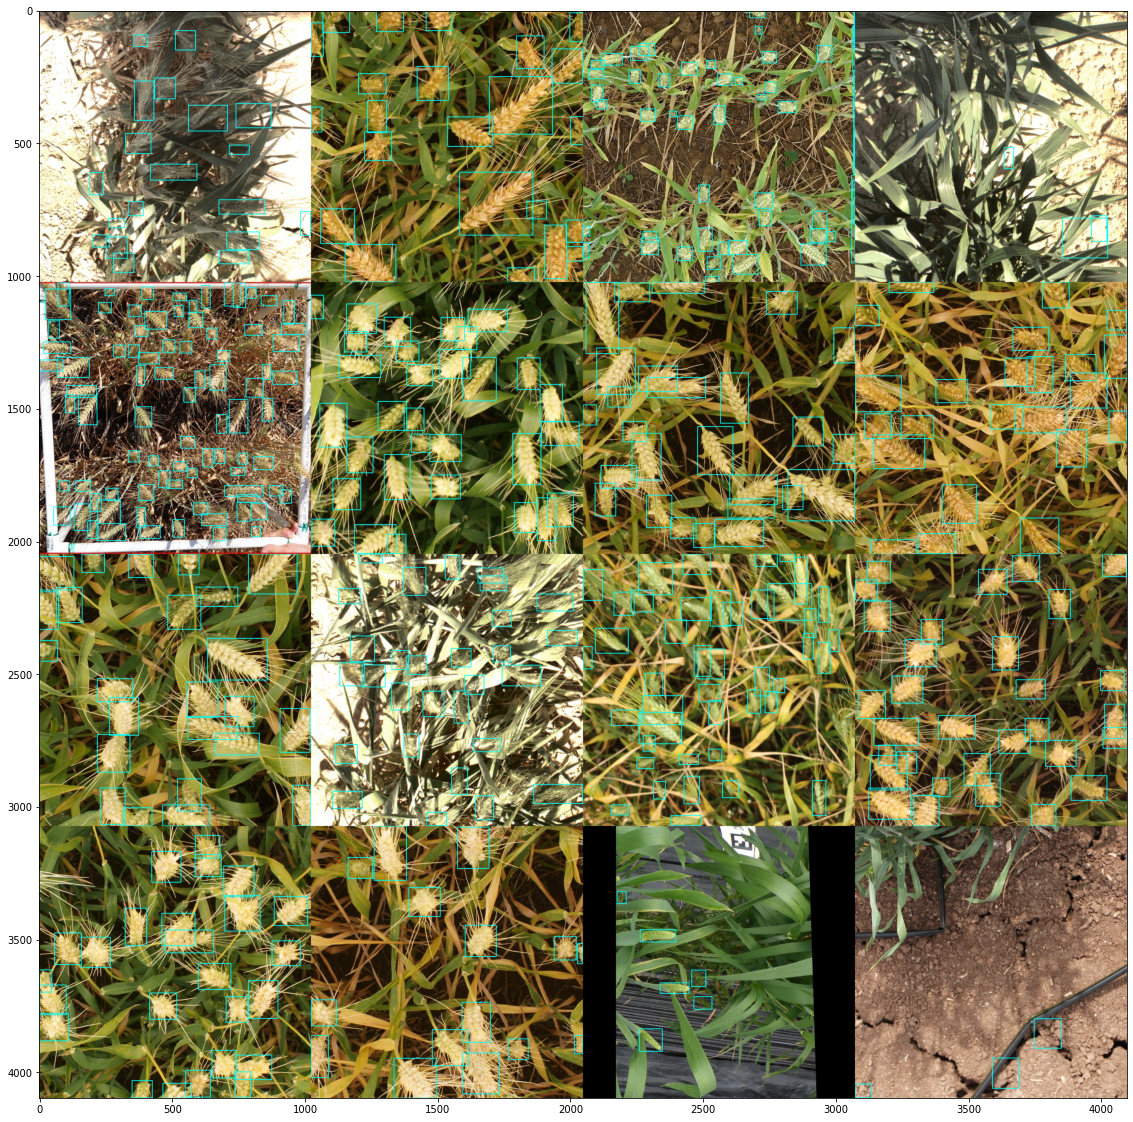

In [7]:
hlines = []
for i in range(4):
  vlines = []
  for j in range(4):
    idx = random.randint(0, len(test_dataset))

    norm_img, img , img_name, domain = test_dataset[idx] # norm_image is used for prediction and img for visualisation

    result = inference_detector(model, img)

    pboxes = result[0][:, 0:4]
    scores = result[0][:, 4]
    pboxes = pboxes[scores > 0.5]

    for (x, y, xx, yy) in pboxes:
      cv2.rectangle(img, (int(x.item()), int(y.item())), (int(xx.item()), int(yy.item())), (0, 255, 255), 2)

    vlines.append(img)
  hlines.append(cv2.vconcat(vlines))

final_img = cv2.hconcat(hlines)

fig ,ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(final_img)

In [8]:
from tqdm import tqdm_notebook as tqdm

def collate_fn(batch):
    """
    Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

    :param batch: an iterable of N sets from __getitem__()
    :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
    """

    norm_images = list()
    images = list()
    image_names = list()
    metadata = list()

    for i, t, n, d in batch:
        norm_images.append(i)
        images.append(t)
        image_names.append(n)
        metadata.append(d)

    return norm_images, images, image_names, metadata

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

def encode_boxes(boxes):
  if len(boxes) > 0:
    boxes = [" ".join([str(int(i)) for i in item]) for item in boxes]
    BoxesString = ";".join(boxes)
  else:
    BoxesString = "no_box"
  return BoxesString

results = []
for batch in tqdm(test_dataloader):
  norm_img, img, img_names, metadata = batch

  predictions = inference_detector(model, img)

  for img_name, pred, domain in zip(img_names, predictions, metadata):
    boxes = pred[0][:, 0:4]
    scores = pred[0][:, 4]
    boxes = boxes[scores > 0.5]

    PredString = encode_boxes(boxes)
    results.append([img_name,PredString,domain.item()])

/home/ogidif/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/357 [00:00<?, ?it/s]

In [9]:
results = pd.DataFrame(results,columns =["image_name","PredString","domain"])
results.to_csv("submission_final.csv")

In [10]:
results

,image_name,PredString,domain
0,c087c8b89904edee56997a25d64f4cd1b7c9441e64889a...,806 597 887 635;551 55 610 120;494 208 531 318...,18
1,b11a617a64ca6120021e70b107933ddb70bf052395759d...,183 636 291 690;680 922 747 989;571 959 640 99...,18
2,4fd7a4dc7dc60b5daedc7d57fdf8000ef3cab267654b56...,270 16 386 115;972 631 1019 670;40 9 148 59;18...,18
3,3f60fada17caf269a8d70798eb3bb5771f2c10d13c887e...,865 562 978 626;544 493 618 528;271 0 367 107;...,18
4,8cdcb28a926c217d0b587fcba2050e283b3175824a5b6e...,587 532 630 575;120 514 196 556;402 882 469 91...,18
...,...,...,...
2844,488ea848ee35b06b561c2aa525c75705aee00d0e3f7dd6...,428 725 460 766;234 492 277 539;546 954 581 995,46
2845,fdd6a2154713b72644a3f818f4318a48816aa2779aad13...,664 707 789 844;375 538 480 594;264 948 327 10...,46
2846,4444cfa1f1f96c17c80ee5c918279313bd134fb743b7ba...,467 151 579 256;407 314 456 403;106 709 242 79...,46
2847,dd5a7bbca426d211984d6ea6595b2976ed77652791936a...,211 690 348 818;250 80 390 232;784 670 989 771...,46


In [12]:
!aicrowd submission create -c global-wheat-challenge-2021 -f submission_final.csv

submission_final.csv ━━━━━━━━━━━━━━━━ 100.0% • 1.6/1.6 MB • 422.6 kB/s • 0:00:00
Submission Upload Error: Couldn't decode response from AIcrowd servers
